### Purely a script for using geospatial data (as prepared in other scripts) for visualisations to be used in Slides and Reports

## Import packages

In [12]:
import riselib

### Functions

In [2]:
def get_files(root_folder, file_type, id_text, subfolder=""):
    """Basic function to walk through folder and return all files of a certain type containing specific text in its name. """
    
    searched_files = []
    folder = os.path.join(root_folder, subfolder)
    
    for dirpath, subdirs, files in os.walk(folder):
        for file in files:
            if (file.endswith(file_type)) & (id_text in file) :
                searched_files.append(os.path.join(os.path.normpath(dirpath), file))

    
    return searched_files

In [3]:
def combine_shape_files(root_folder, id_text, crs = {'init': 'epsg:4326'}, subfolder=""):
    
    """Function to combine multi-part shape files from various countries in a single folder or location into a single
        GeoPandas dataframe"""
    
    shp_files = get_files(root_folder, "shp", id_text, subfolder)
    single_shp_file = gpd.GeoDataFrame(pd.concat([gpd.read_file(shp)for shp in shp_files]), crs= default_crs)

    return single_shp_file

In [4]:
def merge_raster(root_folder, subfolder, file_suffix, file_id, bounds, resolution):
    '''Function to search for and merge rasters from a common source, clip and resample at specified resolution'''
    
    files = get_files(root_folder, file_suffix, file_id, subfolder)
    
    tiles = []
    
    for file in files:
        tiles.append(rasterio.open(file))
        
    merged_raster, merged_transform = rasterio.merge.merge(tiles, bounds = bounds, res=resolution)
    
    for tile in tiles:
        tile.close()
    
    ## single-band data so return this only
    
    return merged_raster, merged_transform
    

In [5]:
def write_raster(path, img, transform, crs= {'init': 'epsg:4326'}, nodata = None):
    
    
    ## Default is 0 = band, 1 = rows, 2 = columns.
    ## Declared out of loop
    width = img.shape[2]
    height = img.shape[1]
    
    if len(img.shape) == 2:
        width = img.shape[1]
        height = img.shape[0]
    
    out_kwargs = {'driver':'GTiff', 'dtype': img.dtype, 'nodata':nodata, 'width':width,
              'height':height, 'count':1, 'crs':crs, 'transform': transform,
              'tiled':False, 'interleave':'band'}
    
    with rasterio.open(path, "w", **out_kwargs) as dest:
        dest.write(img)  
    
    
    

In [6]:
##  Create a geospatial grid based on passed info on the terminal lat/lon points and the resolution
##  Now using overlay!

from shapely.geometry import Polygon
from shapely.geometry import Point

## Define lat1 etc for clipping
def create_geo_grid(adm_df, lat_res, lon_res, geom='poly', clip_lats=None):
   
    #  Make array of shapely Polygon geometries from the lons/lats above
    #  The specified points are centroids of the grids
    ### ERA5 reference for spatial grid is here: https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference
   
    if clip_lats == None:
        lon1, lat1, lon2, lat2 = adm_df.total_bounds
    else:
        lon1, lat1, lon2, lat2 = clip_lats

    lon1 = np.floor(np.divide(lon1,lon_res))*lon_res
    lat1 = np.floor(np.divide(lat1,lat_res))*lon_res
    lon2 = np.ceil(np.divide(lon2,lon_res))*lon_res
    lat2 = np.ceil(np.divide(lat2,lat_res))*lat_res
    
    ## Ensure the centroid remains the referenceable point with RE Ninja, ERA, etc
    grid_lats = np.arange(lat1, lat2 +lat_res, lat_res)  # all Latitudes except the absolute extremities
    grid_lons = np.arange(lon1, lon2 +lon_res, lon_res) # all longitudes except the absolute extremities

    geom_poly = []
    geom_point = []
    lats = []
    lons = []
    
    
    with progressbar.ProgressBar(max_value=len(grid_lats)*len(grid_lons)) as bar:
        grid_count = 0

        for lon in grid_lons:
            for lat in grid_lats:
                poly = Polygon([(lon-lon_res/2, lat-lat_res/2), (lon+lon_res/2,lat-lat_res/2), (lon+lon_res/2,lat+lat_res/2),
                                (lon-lon_res/2,lat+lat_res/2), (lon-lon_res/2,lat-lat_res/2)])
                
                point = Point(lon, lat)
    
                
                geom_poly.append(poly)
                geom_point.append(point)
                lats.append(lat)
                lons.append(lon)
                grid_count += 1
                bar.update(grid_count)


    
    grid = gpd.GeoDataFrame({'grid_id':np.arange(0,len(geom_poly)), 'lat':lats, 'lon':lons},
                                    geometry=geom_poly, crs=adm_df.crs)

    ##  Filter out non-China polygons OR just add china_regional info which allows easy filtering later with NaN etc
    grid = gpd.overlay(grid, adm_df, how='intersection', keep_geom_type=False)

    print('# of latitude divisions is: {}, # of latitude divisions is: {}. Total points: {}'.format(len(grid_lats),
                                                                                                    len(grid_lons), 
                                                                                                len(grid_lats)*len(grid_lons)))

    grid = grid.rename(columns={'index_right':'adm_id'})


    return grid

In [7]:
##  Create a geospatial grid based on specifications of the resource grid. This is for reference with dimensions only
##  and allows for bins etc

from shapely.geometry import Polygon

def create_ref_geo_grid(adm_df, lat_res, lon_res, bin_name='grid_bin', clip_lats=None):
   
   
    #  Make array of shapely Polygon geometries from the lons/lats above
    #  The specified points are centroids of the grids
    ### ERA5 reference for spatial grid is here: https://confluence.ecmwf.int/display/CKB/ERA5%3A+What+is+the+spatial+reference
   
    if clip_lats == None:
        lon1, lat1, lon2, lat2 = adm_df.total_bounds
    else:
        lon1, lat1, lon2, lat2 = clip_lats
    
    lon1, lat1, lon2, lat2 = adm_df.total_bounds

    lon1 = np.floor(np.divide(lon1,lon_res))*lon_res
    lat1 = np.floor(np.divide(lat1,lat_res))*lon_res
    lon2 = np.ceil(np.divide(lon2,lon_res))*lon_res
    lat2 = np.ceil(np.divide(lat2,lat_res))*lat_res
    
    ## Ensure the centroid remains the referenceable point with RE Ninja, ERA, etc
    grid_lats = np.arange(lat1, lat2 +lat_res, lat_res)  # all Latitudes except the absolute extremities
    grid_lons = np.arange(lon1, lon2 +lon_res, lon_res) # all longitudes except the absolute extremities

    geom_poly = []
    geom_point = []
    lats = []
    lons = []
    
    
    with progressbar.ProgressBar(max_value=len(grid_lats)*len(grid_lons)) as bar:
        grid_count = 0

        for lon in grid_lons:
            for lat in grid_lats:
                poly = Polygon([(lon-lon_res/2, lat-lat_res/2), (lon+lon_res/2,lat-lat_res/2), (lon+lon_res/2,lat+lat_res/2),
                                (lon-lon_res/2,lat+lat_res/2), (lon-lon_res/2,lat-lat_res/2)])
                
                point = Point(lon, lat)
    
                
                geom_poly.append(poly)
                geom_point.append(point)
                lats.append(lat)
                lons.append(lon)
                grid_count += 1
                bar.update(grid_count)


    
    grid = gpd.GeoDataFrame({bin_name:np.arange(0,len(geom_poly)), 'lat':lats, 'lon':lons},
                                    geometry=geom_poly, crs=adm_df.crs)


    print('# of latitude divisions is: {}, # of latitude divisions is: {}. Total points: {}'.format(len(grid_lats),
                                                                                                    len(grid_lons), 
                                                                                                  len(grid_lats)*len(grid_lons)))

    return grid

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.ticker as ticker


def apply_iea_style(ax, tick_spacing=20):
    ### Remove frame
    sns.despine(ax=ax, left=True, top=True, bottom= True, right=True)

    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['legend.title_fontsize'] = 10
    plt.rcParams['font.family'] = 'Arial'

    
    ## Add gridlines
    plot_ax = ax.get_figure().get_axes()[0]
    plot_ax.grid(False)
    plot_ax.grid(b=True, axis='y', color='gray', linestyle='--')
    plot_ax.grid(clip_on=False)

    ## Force y-axis tick spacing to each 20deg
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    plot_ax.set_yticklabels(['{}\xb0 N'.format(int(y)) if y > 0 else '{}\xb0 S'.format(int(abs(y))) if y < 0 
                                 else '{}\xb0'.format(int(y)) for y in plot_ax.get_yticks()])


    ## Hide x-axis
    ax.get_xaxis().set_visible(False)

    ## Plot gridlines etc below the map
    ax.set_axisbelow(True)

In [9]:
def simplify_geom_collection(geom):
    
    poly_list =[]
    if type(geom) == shapely.geometry.collection.GeometryCollection:
        for g in geom:
            ##  Not sure if MultiPolygon is ever present...checked and it is not. 
            if (type(g) == shapely.geometry.Polygon):
                poly_list.append(g)
        return shapely.geometry.MultiPolygon(poly_list)
    else:
        return geom

### GIS visualisation functions and set-up

#### Main geographical ADM layers

In [16]:
##  Issues with the CRS disappearing and the concatenation of multiple read shapefiles without a CRS implicit
from pyproj import CRS

default_crs = CRS('EPSG:4326')
utm_crs = CRS('EPSG:3857')

In [13]:
#### for outer sections
ukr_gis_folder = "Y:/GIS/Ukraine/"
eu_gis_folder = 'Y:/GIS/Europe/'

ukr_adm_shp_files = get_files(ukr_gis_folder, "shp", "adm1.")
ukr_adm0_shp_files = get_files(ukr_gis_folder, "shp", "UKR_neighbours_adm0")
eu_adm0_shp_files = get_files(eu_gis_folder, "shp", "adm0")


### Pre-made clipped RUS polygon. Easier to do such things in QGIS
ukr_plus_iso = ['RUS_adm0_UKR_border', 'POL', 'SVK', 'ROU', 'POL', 'MDA', 'BLR', 'HUN']
ukr_plus_adm_shp_files = [s for s in eu_adm0_shp_files if any(xs in s for xs in ukr_plus_iso)] + ukr_adm_shp_files

ukr_adm = gpd.GeoDataFrame(pd.concat([gpd.read_file(shp)for shp in ukr_adm_shp_files]), crs= default_crs)
ukr_adm = ukr_adm.rename(columns={'ISO':'GID_0'})

ukr_adm_plus = gpd.GeoDataFrame(pd.concat([gpd.read_file(shp)for shp in ukr_plus_adm_shp_files]), crs= default_crs)
ukr_adm_plus = ukr_adm_plus.rename(columns={'ISO':'GID_0'})

ukr_regs = pd.read_csv('Y:/GIS/Ukraine/ukr_modelling_regs.csv')
ukr_adm = gpd.GeoDataFrame(pd.merge(ukr_adm, ukr_regs, on='NAME_1', how='left'))
ukr_adm_plus = gpd.GeoDataFrame(pd.merge(ukr_adm_plus, ukr_regs, on='NAME_1', how='left'))
ukr_adm_plus.loc[ukr_adm_plus.PLEXOS_GRP1.isna(), 'PLEXOS_GRP1'] = ukr_adm_plus.loc[ukr_adm_plus.PLEXOS_GRP1.isna(), 'GID_0']

#### Colour palettes

In [14]:
reg_cmap = colors.ListedColormap([ iea_palette[reg_palette[c]] for c in reg_palette.keys()])


#### Functions

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import matplotlib.ticker as ticker


def apply_iea_style(ax, tick_spacing=20):
    ### Remove frame
    sns.despine(ax=ax, left=True, top=True, bottom= True, right=True)

    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['axes.titlesize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['legend.fontsize'] = 10
    plt.rcParams['legend.title_fontsize'] = 10
    plt.rcParams['font.family'] = 'Arial'

    
    ## Add gridlines
    plot_ax = ax.get_figure().get_axes()[0]
    plot_ax.grid(False)
    plot_ax.grid(b=False, axis='y')
    plot_ax.grid(clip_on=False)

    ## Force y-axis tick spacing to each 20deg
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
#     plot_ax.set_yticklabels(['{}\xb0 N'.format(int(y)) if y > 0 else '{}\xb0 S'.format(int(abs(y))) if y < 0 
#                                  else '{}\xb0'.format(int(y)) for y in plot_ax.get_yticks()])


    ## Hide x-axis
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ## Plot gridlines etc below the map
    ax.set_axisbelow(True)

#### Admin summary plots

In [18]:
global_oceans = gpd.read_file('Y:/GIS/global/oceans/ne_10m_ocean.shp').to_crs(default_crs)

NameError: name 'gpd' is not defined

In [21]:
ukr_adm.columns

Index(['ID_0', 'GID_0', 'NAME_0', 'ID_1', 'NAME_1', 'TYPE_1', 'ENGTYPE_1',
       'NL_NAME_1', 'VARNAME_1', 'geometry', 'TA_GRP', 'PZ_GRP', 'PLEXOS_GRP1',
       'PLEXOS_GRP2'],
      dtype='object')

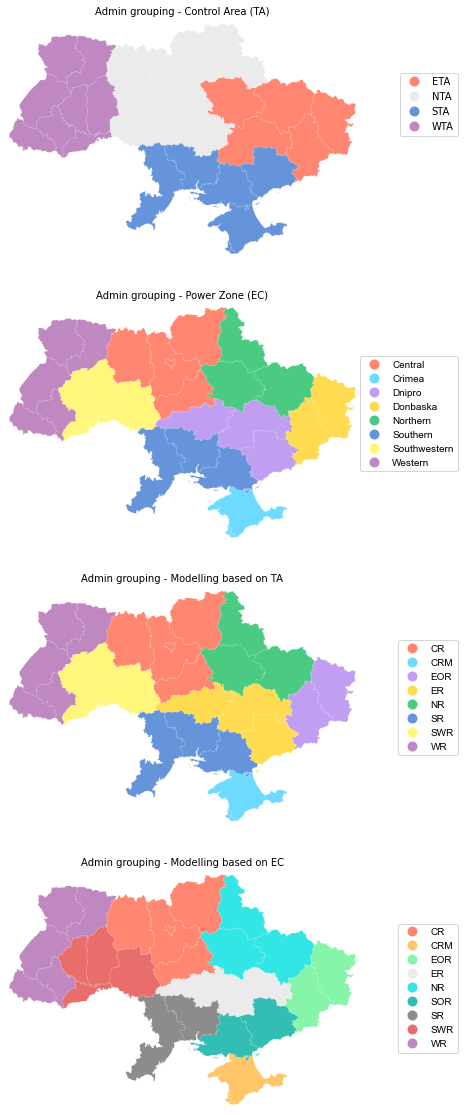

In [22]:
### ADMIN LAYERS##################################################
###################################################################

cm_from_in = 1/2.54
from matplotlib.gridspec import GridSpec

# initialize a plot-grid with 3 axes (2 plots and 1 colorbar)
nr_plots = 4


fig, axs = plt.subplots(nr_plots, figsize=(10*nr_plots, 5*nr_plots))
left_lim, lower_lim, right_lim, upper_lim = ukr_adm.total_bounds

adm_grp = {'TA_GRP':'Control Area (TA)', 'PZ_GRP':'Power Zone (EC)', 'PLEXOS_GRP1':'Modelling based on TA',
           'PLEXOS_GRP2':'Modelling based on EC'}

for i, ax in enumerate(axs):

    ax.set_xlim(left=left_lim-0.1, right=right_lim+0.1)
    ax.set_ylim(bottom=lower_lim-0.1, top=upper_lim+0.1)
    col = list(adm_grp.keys())[i]

    #########
    ukr_adm.plot(ax=ax, column=col, cmap=iea_cmap_14, alpha = 0.8, edgecolor=iea_palette['white'],
                 linewidth=0.1, legend=True, legend_kwds ={'bbox_to_anchor': (1.3, 0.8)})


    apply_iea_style(ax, tick_spacing=5)
    ax.set_title('Admin grouping - {}'.format(adm_grp[col]))
    
fig.savefig('Y:/Modelling/Ukraine/2023_UKR_ST_Security/UKR_adm_groupings', dpi=150, bbox_inches="tight" )

### Transmission analysis

In [23]:
ukr_osm_tx = gpd.read_file("Y:/GIS/Ukraine/tx/ukr_plus_tx_oim.gpkg")
ukr_digitised_tx = gpd.read_file("Y:/GIS/Ukraine/tx/ukr_tx_digitized.shp")

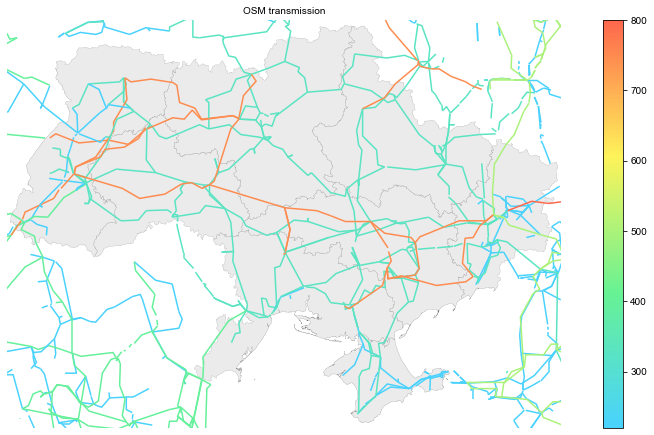

In [24]:
### TRANSMISSION LAYERS##################################################
###################################################################

cm_from_in = 1/2.54
from matplotlib.gridspec import GridSpec

# initialize a plot-grid with 3 axes (2 plots and 1 colorbar)

fig, ax = plt.subplots(1, figsize=(15, 7.5))
left_lim, lower_lim, right_lim, upper_lim = ukr_adm.total_bounds

ax.set_xlim(left=left_lim-0.1, right=right_lim+0.1)
ax.set_ylim(bottom=lower_lim-0.1, top=upper_lim+0.1)
col = list(adm_grp.keys())[i]

#########
ukr_adm.dissolve(by='PLEXOS_GRP1').plot(ax=ax, color=iea_palette['grey10'], alpha = 0.8, edgecolor=iea_palette['black'], linewidth=0.1)
ukr_osm_tx.plot(ax=ax, column='voltage', cmap=iea_cmap_BlGnYlRd, legend=True)
ax.set_title('OSM transmission')

apply_iea_style(ax, tick_spacing=5)

    
# fig.savefig('Y:/Modelling/Ukraine/2023_UKR_ST_Security/UKR_adm_groupings', dpi=150, bbox_inches="tight" )




In [25]:
save_dir = "Y:/Modelling/Ukraine/2023_UKR_ST_Security/"

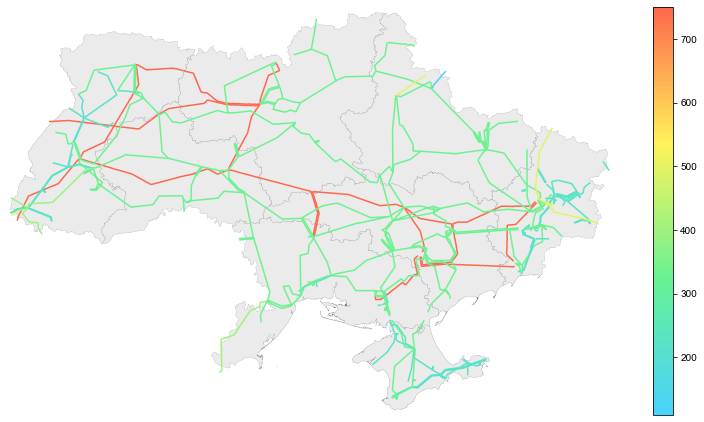

In [26]:
### TRANSMISSION LAYERS##################################################
###################################################################

cm_from_in = 1/2.54
from matplotlib.gridspec import GridSpec

# initialize a plot-grid with 3 axes (2 plots and 1 colorbar)

fig, ax = plt.subplots(1, figsize=(15, 7.5))
left_lim, lower_lim, right_lim, upper_lim = ukr_adm.total_bounds

ax.set_xlim(left=left_lim-0.1, right=right_lim+0.1)
ax.set_ylim(bottom=lower_lim-0.1, top=upper_lim+0.1)
col = list(adm_grp.keys())[i]

#########
ukr_adm.dissolve(by='PLEXOS_GRP1').plot(ax=ax, color=iea_palette['grey10'], alpha = 0.8, edgecolor=iea_palette['black'], linewidth=0.1)
ukr_digitised_tx.plot(ax=ax, column='voltage', cmap=iea_cmap_BlGnYlRd, legend=True)
# ax.set_title('Ukrenegro digitised transmission')

apply_iea_style(ax, tick_spacing=5)
    
fig.savefig(os.path.join(save_dir,"UKR_transmission_map.png"), dpi=150, bbox_inches="tight" )




In [ ]:
zzz

In [30]:
capacity_by_border

,Name,Pattern,Value
0,Line_BLR-CR,M1-12,410.0
4,Line_CR-ER,M1-12,4820.0
5,Line_CR-NR,M1-12,410.0
7,Line_CR-SWR,M1-12,7430.0
8,Line_CR-WR,M1-12,2210.0
9,Line_CRM-SR,M1-12,810.0
10,Line_EOR-ER,M1-12,7840.0
11,Line_EOR-NR,M1-12,810.0
13,Line_ER-NR,M1-12,810.0
14,Line_ER-SR,M1-12,9050.0


#### Plots for analysis

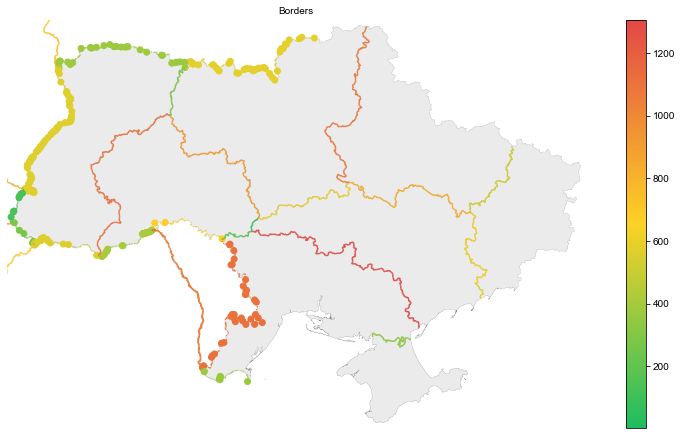

In [31]:
### TRANSMISSION LAYERS##################################################
###################################################################

cm_from_in = 1/2.54
from matplotlib.gridspec import GridSpec

# initialize a plot-grid with 3 axes (2 plots and 1 colorbar)

fig, ax = plt.subplots(1, figsize=(15, 7.5))
left_lim, lower_lim, right_lim, upper_lim = ukr_adm.total_bounds

ax.set_xlim(left=left_lim-0.1, right=right_lim+0.1)
ax.set_ylim(bottom=lower_lim-0.1, top=upper_lim+0.1)

#########
ukr_adm.dissolve(by='PLEXOS_GRP1').plot(ax=ax, color=iea_palette['grey10'], alpha = 0.8, edgecolor=iea_palette['black'], linewidth=0.1)
border_df.plot(ax=ax, column = 'border_len_km', cmap=iea_cmap_RdYlGn_rd, legend=True)
ax.set_title('Borders')

apply_iea_style(ax, tick_spacing=5)

# fig.savefig('Y:/Modelling/Ukraine/2023_UKR_ST_Security/UKR_adm_groupings', dpi=150, bbox_inches="tight" )

In [48]:
zzzzzz

'BLR-CR'

Calculate the intersection of each line with each border

  regA regB                                           geometry   name  \
4   CR   ER  MULTILINESTRING ((32.87844 49.22034, 32.87827 ...  CR-ER   

   border_len_km  
4     592.316449  


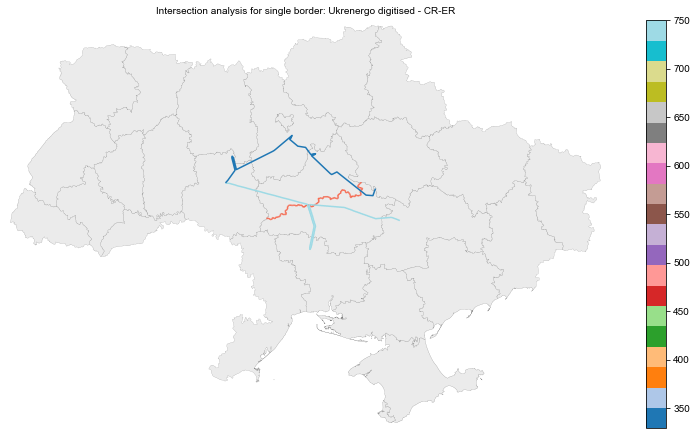

In [53]:
### TRANSMISSION LAYERS##################################################
###################################################################

cm_from_in = 1/2.54
from matplotlib.gridspec import GridSpec

# initialize a plot-grid with 3 axes (2 plots and 1 colorbar)

fig, ax = plt.subplots(1, figsize=(15, 7.5))
left_lim, lower_lim, right_lim, upper_lim = ukr_adm.total_bounds

ax.set_xlim(left=left_lim-0.1, right=right_lim+0.1)
ax.set_ylim(bottom=lower_lim-0.1, top=upper_lim+0.1)

#########
i=4
print(border_df.iloc[i:i+1,])
ukr_adm.plot(ax=ax, color=iea_palette['grey10'], alpha = 0.8, edgecolor=iea_palette['black'], linewidth=0.1)
border_df.iloc[i:i+1,].plot(ax=ax, color=iea_palette['rl'], legend=True)
ukr_digitised_tx[ukr_digitised_tx[border_df.iloc[i:i+1,].name.iloc[0]] == 1].plot(ax=ax, column='voltage', cmap = 'tab20', legend=True)


ax.set_title('Intersection analysis for single border: Ukrenergo digitised - {}'.format(border_df.iloc[i:i+1,].name.iloc[0]))
             

apply_iea_style(ax, tick_spacing=5)

# fig.savefig('Y:/Modelling/Ukraine/2023_UKR_ST_Security/UKR_adm_groupings', dpi=150, bbox_inches="tight" )

In [55]:
ukr_digitised_tx.to_file('Y:/GIS/Ukraine/tx/ukr_tx_digitized_w_reg_intersections.shp')
# border_df.to_file('Y:/GIS/Ukraine/adm/ukr_adm_reg_borders.gpkg', driver='GPKG')

### END ####

##### Import UKR grid data for population analsyis?

In [56]:
ukr_selection_summary = gpd.read_feather('Y:/GIS/Ukraine/20230613_ukr_selection_summary_rev4_COMPLETE.feather')

ImportError: Missing optional dependency 'pyarrow.feather'. pyarrow is required for Feather support.  "
        "Use pip or conda to install pyarrow.feather.